In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [2]:
#定义变量
thermal_power_station_strategy=np.zeros(shape=(54,1000)) 
wind_power_station_strategy=np.zeros(shape=(6,1000))
thermal_power_station_dual_variable=np.zeros(shape=(54,1000))
wind_power_station_dual_variable=np.zeros(shape=(6,1000))
E=np.loadtxt("IEEE-118-doubly-stochastic-weight-matrix.txt")
thermal_power_station_cost=np.zeros(shape=(1,1000)) #火力发电成本
wind_power_station_cost=np.zeros(shape=(1,1000)) #风力发电成本
sum_cost=np.zeros(shape=(1,1000)) #总发电成本
sum_thermal_wind_power_station_strategy=np.zeros(shape=(1,1000))#总发电量
#火力发电站的相关数据  其中54号为拜占庭
generator_a_values= np.loadtxt("./real-data/generator_a_values.txt")#每个agent的成本函数中的超参数a
generator_b_values= np.loadtxt("./real-data/generator_b_values.txt")#每个agent的成本函数中的超参数a
generator_c_values= np.loadtxt("./real-data/generator_c_values.txt")#每个agent的成本函数中的超参数a
thermal_power_station_P_max= np.loadtxt("./real-data/generator_Pmax_values.txt")#每个agent的资源量的上界
thermal_power_station_P_min= np.loadtxt("./real-data/generator_Pmin_values.txt")#每个agent的资源量的下界
#55 56 57 58 59 60号诚实风能的成本相关数据 其中58号为拜占庭 
wind_power_station_varphi=[1,6,1,6,1,6]
wind_power_station_v_in=[3,4,5,3,4,5]
wind_power_station_v_out=[25,45,25,45,25,45]
wind_power_station_v_r=[13,15,16,13,15,16]
wind_power_station_sigma_ue=[3,5,3,5,3,5]
wind_power_station_sigma_oe=[20,30,20,30,20,30]
wind_power_station_P_r=[150,160,150,160,150,160]
wind_power_station_P_min=[0,0,0,0,0,0]
wind_power_station_P_max=[500,300,400,200,300,200]
#不确定性的参数 时变参数
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(100,10).txt") #时变的需求侧用电需求  
c_wind_speed= np.loadtxt("./real-data/weibull_scale_c.txt")      
kappa_wind_speed= np.loadtxt("./real-data/weibull_shape_wk.txt") 
#迭代步长
step_size_primal=5
step_size_dual=5
#正则化参数
regularization_parameter=0.00001

small_Gaussian_Byzantine_attack=np.loadtxt("./data/small_Gaussian_Byzantine_attack_(-1500,30).txt")

In [3]:
#变量初始化
#火力，风力发电策略初始化 诚实
'''for i in range(0,53):
    thermal_power_station_strategy[i][0]=0
for j in range(0,6):
    if j!=3:
        wind_power_station_strategy[j][0]=0'''
for i in range(0,53):
    thermal_power_station_strategy[i][0]=thermal_power_station_P_max[i]
for j in range(0,6):
    if j!=3:
        wind_power_station_strategy[j][0]=thermal_power_station_P_max[j]
        
#拜占庭发电站发电策略初始化 拜占庭
thermal_power_station_strategy[53][0]=0
wind_power_station_strategy[3][0]=0
#诚实用户的初始总发电策略
'''sum_thermal_wind_power_station_strategy[0][0]=0'''
#诚实用户的初始总发电策略
for i in range(0,53):
    sum_thermal_wind_power_station_strategy[0][0]+=thermal_power_station_strategy[i][0]
for j in range(0,6):
    if j!=3:
        sum_thermal_wind_power_station_strategy[0][0]+= wind_power_station_strategy[j][0]

#火力，风力对偶策略初始化 诚实
for i in range(0,53):
    thermal_power_station_dual_variable[i][0]=-1000
for j in range(0,6):
    if j!=3:
        wind_power_station_dual_variable[j][0]=-1000
#拜占庭发电站对偶策略初始化 拜占庭
thermal_power_station_dual_variable[53][0]=small_Gaussian_Byzantine_attack[0]
wind_power_station_dual_variable[3][0]=small_Gaussian_Byzantine_attack[0]

#安全发电站的初始总发电成本 诚实
#火力发电成本
for i in range(0,53):
    thermal_power_station_cost[0][0]=thermal_power_station_cost[0][0]+generator_c_values[i]*thermal_power_station_strategy[i][0]*thermal_power_station_strategy[i][0]+generator_b_values[i]*thermal_power_station_strategy[i][0]+generator_a_values[i]
#风力发电成本
for i in range(0,6):
    if i!=3:
        wind_power_station_cost[0][0]=wind_power_station_cost[0][0]+wind_power_station_varphi[i]*wind_power_station_strategy[i][0]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_r[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][0])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_in[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))
#发电总成本
sum_cost[0][0]=thermal_power_station_cost[0][0]+wind_power_station_cost[0][0]

In [4]:
def Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,generator_a_values,generator_b_values,generator_c_values,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual):
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("***************************small_Gaussian_attack_online_decentralized_economic_dispatch*****************************")
    print("相关变量初始值为：")
    for i in range (0,52):
        print("第",(i+1),"个火力发电站的初始计划发电量为:",thermal_power_station_strategy[i][0])
    for i in range (0,6):
        if i!=3:
            print("第",(i+55),"个风力发电站的初始计划发电量为:",wind_power_station_strategy[i][0])
    print("****************************************************************************")
    for i in range (0,52):
        print("第",(i+1),"个火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[i][0])
    for i in range (0,6):
        if i!=3:
            print("第",(i+55),"个风力发电站的初始对偶变量为:",wind_power_station_dual_variable[i][0])
    print("****************************************************************************")
    print("第",(54),"个受到Byzantin攻击的火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[53][0])
    print("第",(58),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[3][0])
    print("****************************************************************************")
    print("安全发电站的初始总发电量:",sum_thermal_wind_power_station_strategy[0][0])
    print("*************************")
    print("需求侧平均用电需求:",d_power_demand[0])
    print("****************************************************************************")
    print("风速分布参数c:",c_wind_speed[0])
    print("****************************************************************************")
    print("风速分布参数kappa:",kappa_wind_speed[0])
    print("****************************************************************************")
    print("安全发电站的总发电成本：", sum_cost[0][0])
    print("****************************************************************************")
    print("原变量迭代步长为:",step_size_primal)
    print("*****************************************************************************")
    print("对偶变量迭代步长为:",step_size_dual)
    print("*****************************************************************************")
    
    #开始迭代
    for k in range(1,1000):
        #发电站更新计划发电量和对偶变量
        #对偶变量 先做梯度上升 再做聚合
        dual_variable_intermediate=[] #存放当前迭代中60个用户对对偶变量做完梯度下降后得到的中间值
        for i in range(0,53):
            dual_variable_intermediate.append(thermal_power_station_dual_variable[i][k-1]+step_size_dual*((1/60)*thermal_power_station_strategy[i][k-1]-(1/60)*d_power_demand[k-1]-regularization_parameter*thermal_power_station_dual_variable[i][k-1]))
        #添加拜占庭火力发电站的对偶值
        dual_variable_intermediate.append(small_Gaussian_Byzantine_attack[k])
        for j in range(0,6):
            if j==3: #添加拜占庭风力发电站的对偶值
                dual_variable_intermediate.append(small_Gaussian_Byzantine_attack[k])
            else:
                dual_variable_intermediate.append(wind_power_station_dual_variable[j][k-1]+step_size_dual*((1/60)*wind_power_station_strategy[j][k-1]-(1/60)*d_power_demand[k-1]-regularization_parameter*wind_power_station_dual_variable[j][k-1]))
        
        #聚合 安全的火力发电站的对偶更新
        for i in range(0,53):
            weight_aggregation_dual_variable=0
            for j in range(0,54):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i][j]*dual_variable_intermediate[j]               
            for j in range(0,6):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i][j+54]*dual_variable_intermediate[j+54]
            thermal_power_station_dual_variable[i][k]=weight_aggregation_dual_variable
        #聚合 安全的风力发电站的对偶更新
        for i in range(0,6):
            if i!=3:
                weight_aggregation_dual_variable=0
                for j in range(0,54):
                    weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i+54][j]*dual_variable_intermediate[j]               
                for j in range(0,6):
                    weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i+54][j+54]*dual_variable_intermediate[j+54]
                wind_power_station_dual_variable[i][k]=weight_aggregation_dual_variable
        
        #受到Byzantine攻击的火力和风力发电站的对偶更新
        thermal_power_station_dual_variable[53][k]=small_Gaussian_Byzantine_attack[k]
        wind_power_station_dual_variable[3][k]=small_Gaussian_Byzantine_attack[k]            
        
        #安全的火力发电站计划发电量
        for i in range(0,53):
            thermal_power_station_strategy[i][k]=thermal_power_station_strategy[i][k-1]-step_size_primal*(2*generator_c_values[i]*thermal_power_station_strategy[i][k-1]+generator_b_values[i]+(1/60)*thermal_power_station_dual_variable[i][k-1]) 
            if thermal_power_station_strategy[i][k]<=thermal_power_station_P_min[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_min[i]
            elif thermal_power_station_strategy[i][k]>=thermal_power_station_P_max[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_max[i]
        #安全的风力发电站计划发电量
        for i in range(0,6):
            if i!=3:
                wind_power_station_strategy[i][k]=wind_power_station_strategy[i][k-1]-step_size_primal*(wind_power_station_varphi[i]+wind_power_station_sigma_oe[i]+(wind_power_station_sigma_ue[i]+wind_power_station_sigma_oe[i])*math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(-wind_power_station_sigma_ue[i]-wind_power_station_sigma_oe[i])*math.exp(-(math.pow((wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k-1])/wind_power_station_P_r[i]),kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(1/60)*wind_power_station_dual_variable[i][k-1])
                if wind_power_station_strategy[i][k]<=wind_power_station_P_min[i]:
                    wind_power_station_strategy[i][k]=wind_power_station_P_min[i]
                elif wind_power_station_strategy[i][k]>=wind_power_station_P_max[i]:
                    wind_power_station_strategy[i][k]=wind_power_station_P_max[i]
        #受到Byzantine攻击的火力和风力发电站的计划发电量
        thermal_power_station_strategy[53][k]=thermal_power_station_strategy[53][k-1]
        wind_power_station_strategy[3][k]=wind_power_station_strategy[3][k-1]
        
        #安全发电站的计算总计划发电
        #火力发电量
        for i in range(0,53):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+thermal_power_station_strategy[i][k]
        #风力发电量
        for i in range(0,6):
            if i!=3:
                sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+wind_power_station_strategy[i][k]
        
        #安全发电站的计算总发电成本
        #火力发电成本
        for i in range(0,53):
            thermal_power_station_cost[0][k]=thermal_power_station_cost[0][k]+generator_c_values[i]*thermal_power_station_strategy[i][k]*thermal_power_station_strategy[i][k]+generator_b_values[i]*thermal_power_station_strategy[i][k]+generator_a_values[i]
        #风力发电成本
        for i in range(0,6):
            if i!=3:
                wind_power_station_cost[0][k]=wind_power_station_cost[0][k]+wind_power_station_varphi[i]*wind_power_station_strategy[i][k]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_r[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][k])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_in[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))
        #发电总成本
        sum_cost[0][k]=thermal_power_station_cost[0][k]+wind_power_station_cost[0][k]
        
        #输出第k次迭代中的结果 每间隔10次迭代输出一次结果
        if (k+1)%10==0:
            print(k,"次迭代中的结果：")
            for i in range (0,53):
                print("第",(i+1),"个火力发电站的计划发电量为:",thermal_power_station_strategy[i][k])
            for i in range (0,6):
                if i!=3:
                    print("第",(i+55),"个风力发电站的计划发电量为:",wind_power_station_strategy[i][k])
            print("****************************************************************************")
            for i in range (0,53):
                print("第",(i+1),"个火力发电站的对偶变量为:",thermal_power_station_dual_variable[i][k])
            for i in range (0,6):
                if i!=3:
                    print("第",(i+55),"个风力发电站的对偶变量为:",wind_power_station_dual_variable[i][k])
            print("****************************************************************************")
            print("第",(54),"个受到Byzantin攻击的火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[53][k])
            print("第",(58),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[3][k])
            print("****************************************************************************")
            print("安全发电站的总发电量:",sum_thermal_wind_power_station_strategy[0][k])
            print("*************************")
            print("需求侧平均用电需求:",d_power_demand[k])
            print("****************************************************************************")
            print("风速分布参数c:",c_wind_speed[k])
            print("****************************************************************************")
            print("风速分布参数kappa:",kappa_wind_speed[k])
            print("****************************************************************************")        
            print("安全发电站的总发电成本：", sum_cost[0][k])
            print("****************************************************************************")
            print("原变量迭代步长为:",step_size_primal)
            print("****************************************************************************")
            print("对偶变量迭代步长为:",step_size_dual)
            print("****************************************************************************")

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
    return None  

In [5]:
Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,generator_a_values,generator_b_values,generator_c_values,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual)

***************************small_Gaussian_attack_online_decentralized_economic_dispatch*****************************
相关变量初始值为：
第 1 个火力发电站的初始计划发电量为: 30.0
第 2 个火力发电站的初始计划发电量为: 30.0
第 3 个火力发电站的初始计划发电量为: 30.0
第 4 个火力发电站的初始计划发电量为: 300.0
第 5 个火力发电站的初始计划发电量为: 300.0
第 6 个火力发电站的初始计划发电量为: 30.0
第 7 个火力发电站的初始计划发电量为: 100.0
第 8 个火力发电站的初始计划发电量为: 30.0
第 9 个火力发电站的初始计划发电量为: 30.0
第 10 个火力发电站的初始计划发电量为: 300.0
第 11 个火力发电站的初始计划发电量为: 350.0
第 12 个火力发电站的初始计划发电量为: 30.0
第 13 个火力发电站的初始计划发电量为: 30.0
第 14 个火力发电站的初始计划发电量为: 100.0
第 15 个火力发电站的初始计划发电量为: 30.0
第 16 个火力发电站的初始计划发电量为: 100.0
第 17 个火力发电站的初始计划发电量为: 30.0
第 18 个火力发电站的初始计划发电量为: 30.0
第 19 个火力发电站的初始计划发电量为: 100.0
第 20 个火力发电站的初始计划发电量为: 250.0
第 21 个火力发电站的初始计划发电量为: 250.0
第 22 个火力发电站的初始计划发电量为: 100.0
第 23 个火力发电站的初始计划发电量为: 100.0
第 24 个火力发电站的初始计划发电量为: 200.0
第 25 个火力发电站的初始计划发电量为: 200.0
第 26 个火力发电站的初始计划发电量为: 100.0
第 27 个火力发电站的初始计划发电量为: 420.0
第 28 个火力发电站的初始计划发电量为: 420.0
第 29 个火力发电站的初始计划发电量为: 300.0
第 30 个火力发电站的初始计划发电量为: 80.0
第 31 个火力发电站的初始计划发电量为: 30.0
第 32 个火力发电站的初始计划发电量为: 30.0


159 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 5.0
第 2 个火力发电站的计划发电量为: 5.0
第 3 个火力发电站的计划发电量为: 5.0
第 4 个火力发电站的计划发电量为: 255.36782079380703
第 5 个火力发电站的计划发电量为: 300.0
第 6 个火力发电站的计划发电量为: 10.0
第 7 个火力发电站的计划发电量为: 100.0
第 8 个火力发电站的计划发电量为: 5.0
第 9 个火力发电站的计划发电量为: 5.0
第 10 个火力发电站的计划发电量为: 300.0
第 11 个火力发电站的计划发电量为: 350.0
第 12 个火力发电站的计划发电量为: 8.0
第 13 个火力发电站的计划发电量为: 8.0
第 14 个火力发电站的计划发电量为: 100.0
第 15 个火力发电站的计划发电量为: 8.0
第 16 个火力发电站的计划发电量为: 100.0
第 17 个火力发电站的计划发电量为: 8.0
第 18 个火力发电站的计划发电量为: 8.0
第 19 个火力发电站的计划发电量为: 100.0
第 20 个火力发电站的计划发电量为: 250.0
第 21 个火力发电站的计划发电量为: 250.0
第 22 个火力发电站的计划发电量为: 85.9533438917509
第 23 个火力发电站的计划发电量为: 85.9533438917509
第 24 个火力发电站的计划发电量为: 200.0
第 25 个火力发电站的计划发电量为: 200.0
第 26 个火力发电站的计划发电量为: 73.4245036326645
第 27 个火力发电站的计划发电量为: 420.0
第 28 个火力发电站的计划发电量为: 420.0
第 29 个火力发电站的计划发电量为: 300.0
第 30 个火力发电站的计划发电量为: 75.33056807291777
第 31 个火力发电站的计划发电量为: 10.0
第 32 个火力发电站的计划发电量为: 5.0
第 33 个火力发电站的计划发电量为: 5.0
第 34 个火力发电站的计划发电量为: 100.0
第 35 个火力发电站的计划发电量为: 100.0
第 36 个火力发电站的计划发电量为: 300.0
第 37 个火力发电站的计划发电量为: 95.35623

309 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 5.0
第 2 个火力发电站的计划发电量为: 5.0
第 3 个火力发电站的计划发电量为: 5.0
第 4 个火力发电站的计划发电量为: 247.31050052226638
第 5 个火力发电站的计划发电量为: 300.0
第 6 个火力发电站的计划发电量为: 10.0
第 7 个火力发电站的计划发电量为: 100.0
第 8 个火力发电站的计划发电量为: 5.0
第 9 个火力发电站的计划发电量为: 5.0
第 10 个火力发电站的计划发电量为: 300.0
第 11 个火力发电站的计划发电量为: 350.0
第 12 个火力发电站的计划发电量为: 8.0
第 13 个火力发电站的计划发电量为: 8.0
第 14 个火力发电站的计划发电量为: 100.0
第 15 个火力发电站的计划发电量为: 8.0
第 16 个火力发电站的计划发电量为: 100.0
第 17 个火力发电站的计划发电量为: 8.0
第 18 个火力发电站的计划发电量为: 8.0
第 19 个火力发电站的计划发电量为: 100.0
第 20 个火力发电站的计划发电量为: 250.0
第 21 个火力发电站的计划发电量为: 250.0
第 22 个火力发电站的计划发电量为: 80.49448440376725
第 23 个火力发电站的计划发电量为: 80.49448440376729
第 24 个火力发电站的计划发电量为: 200.0
第 25 个火力发电站的计划发电量为: 200.0
第 26 个火力发电站的计划发电量为: 67.01166936847159
第 27 个火力发电站的计划发电量为: 420.0
第 28 个火力发电站的计划发电量为: 420.0
第 29 个火力发电站的计划发电量为: 300.0
第 30 个火力发电站的计划发电量为: 72.48492670113048
第 31 个火力发电站的计划发电量为: 10.0
第 32 个火力发电站的计划发电量为: 5.0
第 33 个火力发电站的计划发电量为: 5.0
第 34 个火力发电站的计划发电量为: 100.0
第 35 个火力发电站的计划发电量为: 100.0
第 36 个火力发电站的计划发电量为: 300.0
第 37 个火力发电站的计划发电量为: 96.32

479 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 5.0
第 2 个火力发电站的计划发电量为: 5.0
第 3 个火力发电站的计划发电量为: 5.0
第 4 个火力发电站的计划发电量为: 248.4534306222083
第 5 个火力发电站的计划发电量为: 300.0
第 6 个火力发电站的计划发电量为: 10.0
第 7 个火力发电站的计划发电量为: 100.0
第 8 个火力发电站的计划发电量为: 5.0
第 9 个火力发电站的计划发电量为: 5.0
第 10 个火力发电站的计划发电量为: 300.0
第 11 个火力发电站的计划发电量为: 350.0
第 12 个火力发电站的计划发电量为: 8.0
第 13 个火力发电站的计划发电量为: 8.0
第 14 个火力发电站的计划发电量为: 100.0
第 15 个火力发电站的计划发电量为: 8.0
第 16 个火力发电站的计划发电量为: 100.0
第 17 个火力发电站的计划发电量为: 8.0
第 18 个火力发电站的计划发电量为: 8.0
第 19 个火力发电站的计划发电量为: 100.0
第 20 个火力发电站的计划发电量为: 250.0
第 21 个火力发电站的计划发电量为: 250.0
第 22 个火力发电站的计划发电量为: 81.88217681061191
第 23 个火力发电站的计划发电量为: 81.88217681061192
第 24 个火力发电站的计划发电量为: 200.0
第 25 个火力发电站的计划发电量为: 200.0
第 26 个火力发电站的计划发电量为: 68.67107485785287
第 27 个火力发电站的计划发电量为: 420.0
第 28 个火力发电站的计划发电量为: 420.0
第 29 个火力发电站的计划发电量为: 300.0
第 30 个火力发电站的计划发电量为: 73.22878939619136
第 31 个火力发电站的计划发电量为: 10.0
第 32 个火力发电站的计划发电量为: 5.0
第 33 个火力发电站的计划发电量为: 5.0
第 34 个火力发电站的计划发电量为: 100.0
第 35 个火力发电站的计划发电量为: 100.0
第 36 个火力发电站的计划发电量为: 300.0
第 37 个火力发电站的计划发电量为: 98.625

669 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 5.0
第 2 个火力发电站的计划发电量为: 5.0
第 3 个火力发电站的计划发电量为: 5.0
第 4 个火力发电站的计划发电量为: 249.08822921293427
第 5 个火力发电站的计划发电量为: 300.0
第 6 个火力发电站的计划发电量为: 10.0
第 7 个火力发电站的计划发电量为: 100.0
第 8 个火力发电站的计划发电量为: 5.0
第 9 个火力发电站的计划发电量为: 5.0
第 10 个火力发电站的计划发电量为: 300.0
第 11 个火力发电站的计划发电量为: 350.0
第 12 个火力发电站的计划发电量为: 8.0
第 13 个火力发电站的计划发电量为: 8.0
第 14 个火力发电站的计划发电量为: 100.0
第 15 个火力发电站的计划发电量为: 8.0
第 16 个火力发电站的计划发电量为: 100.0
第 17 个火力发电站的计划发电量为: 8.0
第 18 个火力发电站的计划发电量为: 8.0
第 19 个火力发电站的计划发电量为: 100.0
第 20 个火力发电站的计划发电量为: 250.0
第 21 个火力发电站的计划发电量为: 250.0
第 22 个火力发电站的计划发电量为: 83.27738503898144
第 23 个火力发电站的计划发电量为: 83.27738503898144
第 24 个火力发电站的计划发电量为: 200.0
第 25 个火力发电站的计划发电量为: 200.0
第 26 个火力发电站的计划发电量为: 69.85288948330287
第 27 个火力发电站的计划发电量为: 420.0
第 28 个火力发电站的计划发电量为: 420.0
第 29 个火力发电站的计划发电量为: 300.0
第 30 个火力发电站的计划发电量为: 73.61765376980361
第 31 个火力发电站的计划发电量为: 10.0
第 32 个火力发电站的计划发电量为: 5.0
第 33 个火力发电站的计划发电量为: 5.0
第 34 个火力发电站的计划发电量为: 100.0
第 35 个火力发电站的计划发电量为: 100.0
第 36 个火力发电站的计划发电量为: 300.0
第 37 个火力发电站的计划发电量为: 100.0

839 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 5.0
第 2 个火力发电站的计划发电量为: 5.0
第 3 个火力发电站的计划发电量为: 5.0
第 4 个火力发电站的计划发电量为: 249.11848259576774
第 5 个火力发电站的计划发电量为: 300.0
第 6 个火力发电站的计划发电量为: 10.0
第 7 个火力发电站的计划发电量为: 100.0
第 8 个火力发电站的计划发电量为: 5.0
第 9 个火力发电站的计划发电量为: 5.0
第 10 个火力发电站的计划发电量为: 300.0
第 11 个火力发电站的计划发电量为: 350.0
第 12 个火力发电站的计划发电量为: 8.0
第 13 个火力发电站的计划发电量为: 8.0
第 14 个火力发电站的计划发电量为: 100.0
第 15 个火力发电站的计划发电量为: 8.0
第 16 个火力发电站的计划发电量为: 100.0
第 17 个火力发电站的计划发电量为: 8.0
第 18 个火力发电站的计划发电量为: 8.0
第 19 个火力发电站的计划发电量为: 100.0
第 20 个火力发电站的计划发电量为: 250.0
第 21 个火力发电站的计划发电量为: 250.0
第 22 个火力发电站的计划发电量为: 83.72116120309965
第 23 个火力发电站的计划发电量为: 83.72116120309965
第 24 个火力发电站的计划发电量为: 200.0
第 25 个火力发电站的计划发电量为: 200.0
第 26 个火力发电站的计划发电量为: 70.53006117769716
第 27 个火力发电站的计划发电量为: 420.0
第 28 个火力发电站的计划发电量为: 420.0
第 29 个火力发电站的计划发电量为: 300.0
第 30 个火力发电站的计划发电量为: 73.88478293702775
第 31 个火力发电站的计划发电量为: 10.0
第 32 个火力发电站的计划发电量为: 5.0
第 33 个火力发电站的计划发电量为: 5.0
第 34 个火力发电站的计划发电量为: 100.0
第 35 个火力发电站的计划发电量为: 100.0
第 36 个火力发电站的计划发电量为: 300.0
第 37 个火力发电站的计划发电量为: 100.0

In [6]:
#数据存储
np.savetxt('./data/01_small_Gaussian_Byzantine_attack_sum_cost.txt',sum_cost,fmt='%0.8f')
np.savetxt('./data/01_small_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt',sum_thermal_wind_power_station_strategy,fmt='%0.8f')

In [7]:
#评价指标：动态regret和累计的约束违反

In [8]:
#动态regret

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [10]:
sum_cost=np.loadtxt("./data/01_small_Gaussian_Byzantine_attack_sum_cost.txt")
optimal_sum_cost=np.loadtxt("./data/00_optimal_sum_cost_varying_D_c_kappa_normal_distribution_(100,10).txt")

In [11]:
dynamic_regret=[]
dynamic_regret_T=[]
for T in range(1, 1000):
    dynamic_regret_auxiliary_variable=0
    for t in range(0, T):
        dynamic_regret_auxiliary_variable=dynamic_regret_auxiliary_variable+sum_cost[t+1]-optimal_sum_cost[t+1]
    dynamic_regret.append(dynamic_regret_auxiliary_variable)
    dynamic_regret_T.append((dynamic_regret_auxiliary_variable)/T)

In [12]:
dynamic_regret

[34923.03850531,
 56616.56929345,
 71332.38302634,
 65052.134630450004,
 81145.45737356,
 63184.57843685,
 62437.33902685999,
 51827.49580163999,
 63190.240691440005,
 48612.31622912998,
 32529.04593108999,
 5933.168895749986,
 -14035.03939378001,
 -23467.985285320014,
 -43848.41639037001,
 -52450.964101770005,
 -49009.775302680006,
 -59609.31722828001,
 -46934.11986196,
 -44729.17954497,
 -83994.97355279,
 -77827.54530448001,
 -83048.61790264,
 -90399.6170642,
 -85887.86981227,
 -87115.64978637,
 -100696.17061023001,
 -106256.00301718,
 -110239.14162704001,
 -118652.01144266002,
 -134461.98900886002,
 -136010.40476544003,
 -121303.98363207004,
 -124388.37107056004,
 -93645.94192930004,
 -100773.76415429004,
 -102588.73851581004,
 -89809.65934702003,
 -72768.12895022004,
 -69515.15394284004,
 -64488.45334974004,
 -57695.54009793003,
 -40537.29358125004,
 -58023.56200833003,
 -53531.08602730003,
 -43312.38958376003,
 -27762.207787290026,
 -24591.72769415003,
 -24717.712429660038,
 -3135

In [13]:
#绘图 dynamic_regret和dynamic_regret_T

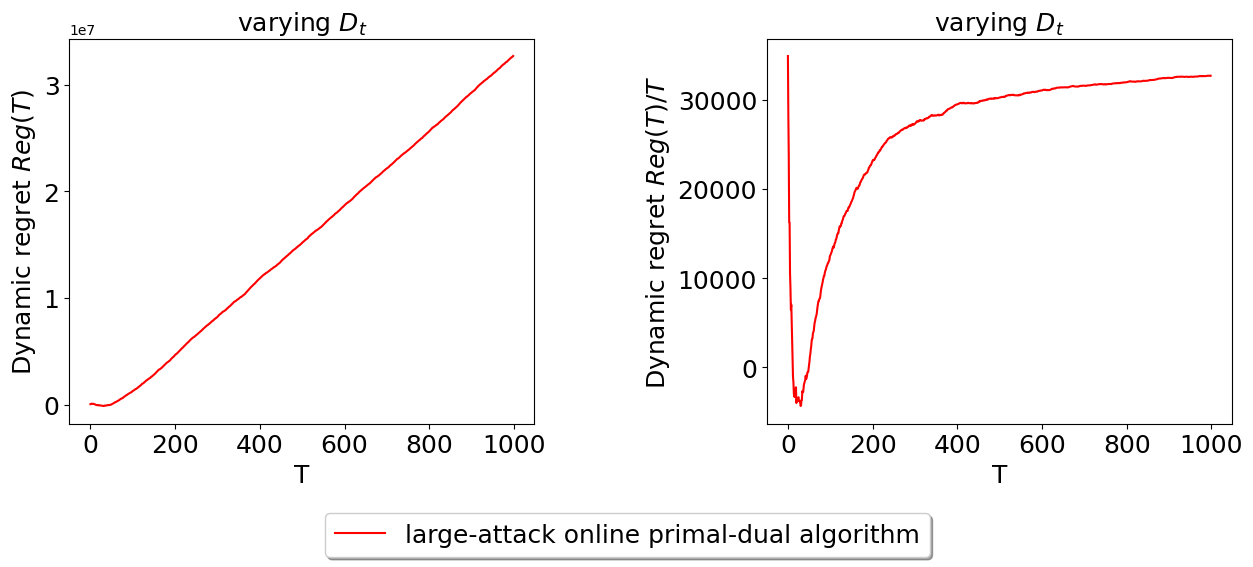

In [14]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret,color = 'red',linewidth = '1.5',label='large-attack online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret_T,color = 'red',linewidth = '1.5',label='large-attack online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))

#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.png',format='png', bbox_inches='tight')

In [15]:
#累计的约束违反

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [17]:
sum_thermal_wind_power_station_strategy=np.loadtxt("./data/01_small_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt")
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(100,10).txt")

In [18]:
accumulative_constraint_violation=[]
accumulative_constraint_violation_T=[]
for T in range(1, 1000):
    accumulative_constraint_violation_auxiliary_variable=0
    for t in range(0, T): 
        accumulative_constraint_violation_auxiliary_variable=accumulative_constraint_violation_auxiliary_variable+(1/58)*sum_thermal_wind_power_station_strategy[t+1]-d_power_demand[t+1]
    accumulative_constraint_violation.append(abs(accumulative_constraint_violation_auxiliary_variable))
    accumulative_constraint_violation_T.append(abs(accumulative_constraint_violation_auxiliary_variable)/T)

In [19]:
accumulative_constraint_violation

[31.98579342931035,
 51.65032192431036,
 65.00328155931037,
 58.97557309465519,
 74.5313872610345,
 57.88395345793106,
 56.96198947948278,
 46.893033312068965,
 58.053005439655166,
 44.293786209137906,
 29.13843400655172,
 4.597315193275847,
 14.082426387413818,
 23.198470163275886,
 42.23493954586209,
 50.573161784137966,
 47.51068202344831,
 57.65479566275866,
 45.26951406568969,
 43.43768123896555,
 78.47430087793106,
 72.79243854603449,
 77.92353461379311,
 84.99713185482759,
 80.98807008327586,
 82.39038032137931,
 95.03332075344828,
 100.39919709189657,
 104.30955931431036,
 112.22878890810347,
 126.7187750948276,
 128.37605053931037,
 114.71006687258622,
 117.75156756310348,
 87.59559698431038,
 94.24972093051728,
 96.12292276982762,
 84.56432228017245,
 68.96947882913797,
 66.2525087532759,
 61.928531262069015,
 56.00379868396557,
 40.49027289655179,
 55.87762391189662,
 52.075556754827645,
 43.084234827241445,
 29.20602140517248,
 26.61176043655179,
 26.951349702931097,
 7.539

In [20]:
#绘图 accumulative_constraint_violation和accumulative_constraint_violation_T

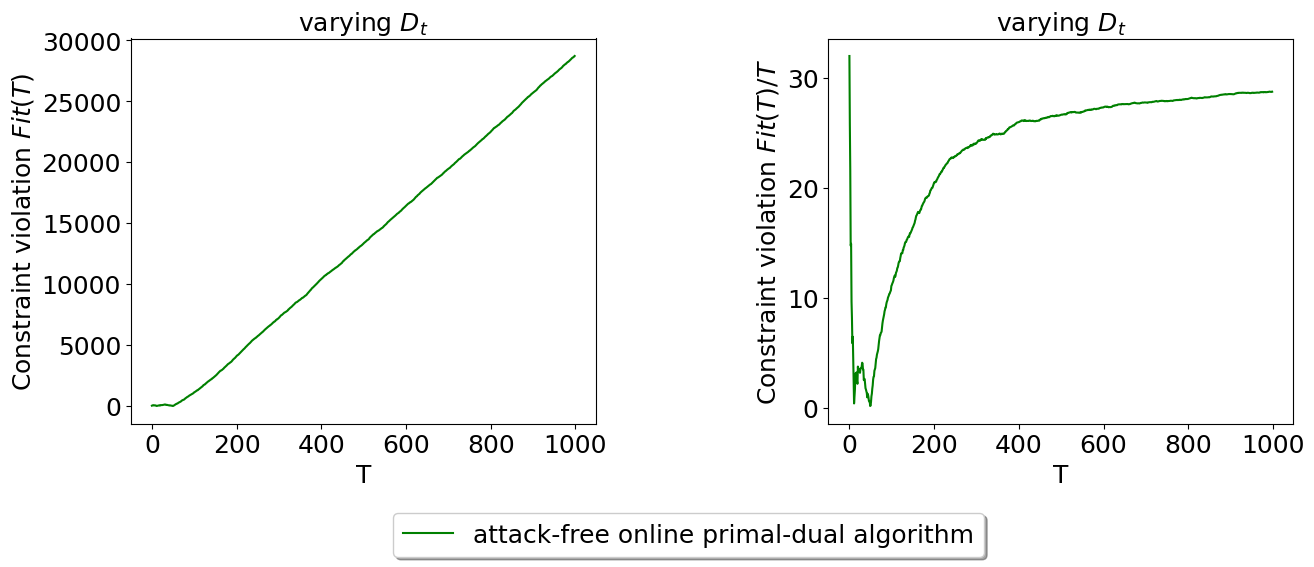

In [21]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation_T,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))


#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.png',format='png', bbox_inches='tight')